In [1]:


import torch
import pandas as pd, psycopg2, os
from sklearn.preprocessing import StandardScaler
import numpy as np  
import torch
from torch.utils.data import Dataset, DataLoader
import joblib
import torch.nn as nn
import datetime as dt
from dotenv import load_dotenv
import matplotlib.pyplot as plt
# --- TensorBoard ---
from torch.utils.tensorboard import SummaryWriter
import time
from BoatRaceDataset import BoatRaceDataset
import itertools

# --- reproducibility helpers ---
import random  # reproducibility helpers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:


load_dotenv(override=True)

DB_CONF = {
    "host":     os.getenv("PGHOST", "localhost"),
    "port":     int(os.getenv("PGPORT", 5432)),
    "dbname":   os.getenv("PGDATABASE", "boatrace"),
    "user":     os.getenv("PGUSER", "br_user"),
    "password": os.getenv("PGPASSWORD", "secret"),
}

# ------------------------------------------------------------------
# DB 接続
# ------------------------------------------------------------------
conn = psycopg2.connect(**DB_CONF)
processed_df = pd.read_sql("""
    SELECT * FROM feat.train_features
    WHERE race_date <= '2024-12-31'
""", conn)

print(f"Loaded {len(processed_df)} rows from the database.")

Loaded 2076 rows from the database.


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15703/946689521.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


In [ ]:


# 風向をラジアンに変換し、sin/cos 特徴量を生成
processed_df["wind_dir_rad"] = np.deg2rad(processed_df["wind_dir_deg"])
processed_df["wind_sin"] = np.sin(processed_df["wind_dir_rad"])
processed_df["wind_cos"] = np.cos(processed_df["wind_dir_rad"])

NUM_COLS = ["air_temp", "wind_speed", "wave_height", "water_temp", "wind_sin", "wind_cos"]
scaler = StandardScaler().fit(processed_df[NUM_COLS])
processed_df[NUM_COLS] = scaler.transform(processed_df[NUM_COLS])

bool_cols = [c for c in processed_df.columns if c.endswith("_fs_flag")]
processed_df[bool_cols] = processed_df[bool_cols].fillna(False)

rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
processed_df[rank_cols] = processed_df[rank_cols].fillna(7).astype("int32")
processed_df.to_csv("artifacts/train_features.csv", index=False)
display(processed_df.head())
print("データフレーム全体の欠損値の総数:", processed_df.isnull().sum().sum())

# 各列の欠損値の割合を表示（0〜1の値）
missing_ratio = processed_df.isnull().mean()

# パーセント表示にする場合（見やすさのため）
missing_ratio_percent = missing_ratio * 100

print("各列の欠損値の割合（%）:")
print(missing_ratio_percent.sort_values(ascending=False))

os.makedirs("artifacts", exist_ok=True)
scaler_filename = "artifacts/wind_scaler.pkl"
joblib.dump(scaler, scaler_filename)

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15703/3957366242.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False)


,race_key,race_date,venue,air_temp,wind_speed,wave_height,water_temp,weather_txt,wind_dir_deg,lane1_racer_id,...,lane6_boat_no_hw,lane6_boat_2in,lane6_boat_3in,lane6_boa_1st,lane6_boa_2nd,lane6_boa_3rd,lane6_boa_starts,wind_dir_rad,wind_sin,wind_cos
0,若松_20240101_1,2024-01-01,若松,-1.464009,-1.163734,-1.205108,-1.263955,晴,67.5,5104,...,29,33.08,48.12,14,30,20,133,1.178097,0.779280,0.288354
1,若松_20240101_10,2024-01-01,若松,-1.338795,-1.163734,-1.205108,-1.263955,晴,67.5,4413,...,28,39.39,51.52,26,26,16,132,1.178097,0.779280,0.288354
2,若松_20240101_11,2024-01-01,若松,-1.464009,-1.811120,-1.205108,-1.263955,晴,NaN,4155,...,64,31.72,50.34,23,23,27,145,NaN,NaN,NaN
3,若松_20240101_12,2024-01-01,若松,-1.464009,-0.516349,-0.543049,-1.263955,晴,67.5,4349,...,46,35.10,50.99,24,29,24,151,1.178097,0.779280,0.288354
4,若松_20240101_2,2024-01-01,若松,-1.213581,-1.163734,-1.205108,-1.263955,晴,22.5,5155,...,65,35.06,50.00,29,25,23,154,0.392699,0.028337,1.278569


データフレーム全体の欠損値の総数: 645
各列の欠損値の割合（%）:
wind_cos             2.312139
wind_dir_rad         2.312139
wind_dir_deg         2.312139
wind_sin             2.312139
lane5_boat_2in       0.867052
                       ...   
lane3_3in_natl       0.000000
lane3_age            0.000000
lane3_class_hist1    0.000000
lane3_class_hist2    0.000000
lane3_boa_2nd        0.000000
Length: 246, dtype: float64


['artifacts/wind_scaler.pkl']

In [ ]:


def encode(col):
    uniq = sorted(processed_df[col].dropna().unique())
    mapping = {v:i for i,v in enumerate(uniq)}
    processed_df[col + "_id"] = processed_df[col].map(mapping).fillna(-1).astype("int16")
    return mapping
venue2id = encode("venue")
# race_type2id = encode("race_type")

In [ ]:


# ============================================================
# 0) ── データの“ラベル & 特徴量”を 1 行だけ覗く可視化 Snippet
#      ★★ ここは notebook なら「1 セルだけ」実行すれば OK ★★
# ------------------------------------------------------------
def peek_one(df: pd.DataFrame, seed: int = 0) -> None:
    """
    ランダムに 1 レース（1 行）だけ抜き取り、順位と主要特徴量を一覧表示
    """
    row = df.sample(1, random_state=seed).squeeze()

    def lane_list(prefix: str):
        return [row[f"lane{i}_{prefix}"] for i in range(1, 7)]

    print("── sample race ──")
    print("rank    :", lane_list("rank"))
    print("exh_time:", lane_list("exh_time"))
    print("st      :", lane_list("st"))
    print("fs_flag :", lane_list("fs_flag"))
    print("weight  :", lane_list("weight"))

# ---------------------------------------------
# ここで一度だけ呼んで目視確認しておくとズレにすぐ気付けます
peek_one(processed_df)
# ============================================================


LANE_DIM = 8
class SimpleCPLNet(nn.Module):
    """
    ctx(6) + boat(4) → lane ごとにスコア 1 個
    """
    def __init__(self, ctx_in=6, boat_in=4, hidden=64, lane_dim=LANE_DIM):
        super().__init__()
        self.lane_emb = nn.Embedding(6, lane_dim)
        self.ctx_fc   = nn.Linear(ctx_in, hidden)
        self.boat_fc  = nn.Linear(boat_in + lane_dim, hidden)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

        # 重み初期化を対称性ブレイク用に Xavier で揃える
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, ctx, boats, lane_ids):  # boats:(B,6,4) lane_ids:(B,6)
        B, L, _ = boats.size()
        ctx_emb  = self.ctx_fc(ctx)           # (B,h)
        # DataLoader から来る lane_ids が (B,) なら (B,6) へブロードキャスト
        # -------- lane_ids の形状を必ず (B,6) にそろえる --------
        if lane_ids.dim() == 1:               # (B,) → (B,6)
            lane_ids = lane_ids.unsqueeze(1).expand(-1, L)
        elif lane_ids.dim() == 2 and lane_ids.size(1) == 1:  # (B,1) → (B,6)
            lane_ids = lane_ids.expand(-1, L)
        # 以外 (既に (B,6)) はそのままで OK
        lane_ids = lane_ids.contiguous()      # Embedding 要求に備え contiguous 化

        lane_emb = self.lane_emb(lane_ids)    # (B,6,lane_dim)
        boat_inp = torch.cat([boats, lane_emb], dim=-1)
        boat_emb = self.boat_fc(boat_inp)     # (B,6,h)

        # broadcast ctx → 各 lane
        score = self.head(torch.tanh(ctx_emb.unsqueeze(1) + boat_emb))  # (B,6,1)
        return score.squeeze(-1)           # (B,6)

── sample race ──
rank    : [np.int32(1), np.int32(3), np.int32(6), np.int32(2), np.int32(5), np.int32(4)]
exh_time: [np.float64(6.93), np.float64(6.94), np.float64(6.95), np.float64(6.93), np.float64(6.95), np.float64(6.89)]
st      : [np.float64(0.14), np.float64(0.07), np.float64(0.03), np.float64(0.0), np.float64(0.01), np.float64(0.07)]
fs_flag : [np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]
weight  : [np.float64(52.9), np.float64(52.3), np.float64(51.0), np.float64(52.0), np.float64(53.2), np.float64(54.5)]


In [6]:


def pl_nll(scores: torch.Tensor, ranks: torch.Tensor) -> torch.Tensor:
    """
    scores : (B, 6) ― lane0 – lane5 のスコア
    ranks  : (B, 6) ― **1 が 1 着, … 6 が 6 着**（列番号ではない）
   """
    scores = scores.clamp(-20.0, 20.0)

    # 着順 (1 → 6) に並んだ lane index を取得
    order = torch.argsort(ranks, dim=1)      # shape (B,6)

    nll = torch.zeros(scores.size(0), device=scores.device)
    s   = scores.clone()
    for pos in range(6):
        log_denom = torch.logsumexp(s, dim=1)            # log Σₗ exp
        idx       = order[:, pos]                        # (B,)
        chosen    = s.gather(1, idx.unsqueeze(1)).squeeze(1)
        nll      += log_denom - chosen
        s         = s.scatter(1, idx.unsqueeze(1), float('-inf'))

    return nll.mean()

# ── pl_nll が正しいか 3 秒で判定 ──
scores = torch.tensor([[6, 5, 4, 3, 2, 1]], dtype=torch.float32)  # lane0 が最強
ranks  = torch.tensor([[1, 2, 3, 4, 5, 6]], dtype=torch.int64)    # lane0 が 1 着
print("pl_nll should be ~0 :", pl_nll(scores, ranks).item())

pl_nll should be ~0 : 2.0691652297973633


In [ ]:


processed_df["race_date"] = pd.to_datetime(processed_df["race_date"]).dt.date
latest_date = processed_df["race_date"].max()
cutoff = latest_date - dt.timedelta(days=90)

mode = "zscore"  # "raw", "log", "zscore" も試せる
ds_train = BoatRaceDataset(processed_df[processed_df["race_date"] <  cutoff], mode=mode)
ds_val   = BoatRaceDataset(processed_df[processed_df["race_date"] >= cutoff], mode=mode)
print(f"train: {len(ds_train)}  val: {len(ds_val)}")
# print("train:", ds_train[0])  # 1 レースの特徴量を確認

loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
loader_val   = DataLoader(ds_val,   batch_size=512)

# ------------------- ⑤ 学習ループ（LR↓ + Clip） --------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = SimpleCPLNet().to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 20
# --- TensorBoard setup ---
log_dir = os.path.join("artifacts", "tb", time.strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)
for epoch in range(EPOCHS):

    if epoch == 0:                  # 1 エポック目だけ試す例
        ctx, boats, lane_ids, ranks = next(iter(loader_train))
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids = lane_ids.to(device)

        scores = model(ctx, boats, lane_ids)
        scores.sum().backward()     # ダミー backward
        grad_norm = sum(p.grad.abs().mean().item() for p in model.parameters())
        print(f"[debug] average |grad| = {grad_norm:.3e}")
    # ---- train ----
    model.train(); tr_sum = 0
    for ctx, boats, lane_ids, ranks in loader_train:
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids, ranks = lane_ids.to(device), ranks.to(device)

        scores = model(ctx, boats, lane_ids)
        pl_loss = pl_nll(scores, ranks)
        pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1  # 1〜6 着になるよう変換
        l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
        loss = pl_loss + 0.3 * l1_loss  # alpha=0.3 は調整可能
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # ★勾配爆発対策★
        opt.step()

        tr_sum += loss.item() * len(ctx)

    tr_nll = tr_sum / len(loader_train.dataset)

    # ---- validation ----
    model.eval(); val_sum = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            scores = model(ctx, boats, lane_ids)
            pl_loss = pl_nll(scores, ranks)
            pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1
            l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
            val_sum += (pl_loss + 0.3 * l1_loss).item() * len(ctx)

    val_nll = val_sum / len(loader_val.dataset)

    print(f"epoch {epoch:2d}  train_nll {tr_nll:.4f}  val_nll {val_nll:.4f}")

    # ---- accuracy & 三連単的中率 ----
    def top1_accuracy(scores, ranks):
        pred_top1 = scores.argmax(dim=1)
        true_top1 = (ranks == 1).nonzero(as_tuple=True)[1]
        return (pred_top1 == true_top1).float().mean().item()

    def trifecta_hit_rate(scores, ranks):
        """
        予測スコア上位3着までと、実際の着順上位3着の組み合わせ一致を見る（順不同）
        """
        pred_top3 = torch.topk(scores, k=3, dim=1).indices
        true_top3 = torch.topk(-ranks, k=3, dim=1).indices  # 小さい順に上位3着
        hit = [set(p.tolist()) == set(t.tolist()) for p, t in zip(pred_top3, true_top3)]
        return sum(hit) / len(hit)

    # accuracy 評価
    model.eval(); all_scores, all_ranks = [], []
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids = lane_ids.to(device)
            scores = model(ctx, boats, lane_ids).cpu()
            all_scores.append(scores)
            all_ranks.append(ranks)

    all_scores = torch.cat(all_scores, dim=0)
    all_ranks = torch.cat(all_ranks, dim=0)

    acc_top1 = top1_accuracy(all_scores, all_ranks)
    acc_tri3 = trifecta_hit_rate(all_scores, all_ranks)
    writer.add_scalar("loss/train_nll",  tr_nll,  epoch)
    writer.add_scalar("loss/val_nll",    val_nll, epoch)
    writer.add_scalar("acc/top1",        acc_top1, epoch)
    writer.add_scalar("acc/trifecta_hit", acc_tri3, epoch)

    # print(f"Top-1 Acc: {acc_top1:.3f}   Trifecta Hit: {acc_tri3:.3f}")

    # ---- 学習ログを CSV へ追記保存 ----
    import csv
    os.makedirs("artifacts", exist_ok=True)
    log_path = f"artifacts/train_{mode}.csv"
    # 1回目だけヘッダーを書き込む
    write_header = epoch == 0 and not os.path.exists(log_path)
    with open(log_path, mode="a", newline="") as f:
        writer_csv = csv.writer(f)
        if write_header:
            writer_csv.writerow(["epoch", "train_nll", "val_nll", "top1_acc", "trifecta_hit"])
        writer_csv.writerow([epoch, tr_nll, val_nll, acc_top1, acc_tri3])


# --- Close TensorBoard writer after training ---
writer.close()

# ---- Permutation Importance ----
def evaluate_model(model, dataset, device):
    model.eval()
    loader = DataLoader(dataset, batch_size=512)
    total_loss = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            loss = pl_nll(model(ctx, boats, lane_ids), ranks)
            total_loss += loss.item() * len(ctx)
    return total_loss / len(dataset)

def permute_importance(model, dataset, device="cpu", cols=None):
    base_loss = evaluate_model(model, dataset, device)

    importances = {}
    df = dataset.f.copy()

    if cols is None:
        cols = ["wind_speed", "wave_height", "air_temp", "water_temp", "wind_dir_deg"]

    for col in cols:
        shuffled_df = df.copy()
        shuffled_df[col] = np.random.permutation(shuffled_df[col].values)
        temp_ds = BoatRaceDataset(shuffled_df, mode=dataset.mode)
        loss = evaluate_model(model, temp_ds, device)
        importances[col] = loss - base_loss  # 悪化分をスコアとする

    return importances

importance_scores = permute_importance(model, ds_val, device, cols=NUM_COLS)
print("▼ 環境特徴量の重要度（val_nll 増加量）:")
for k, v in sorted(importance_scores.items(), key=lambda x: -x[1]):
    print(f"{k:12s}: {v:.4f}")



train: 1699  val: 377
[debug] average |grad| = 2.169e+03
epoch  0  train_nll 7.4078  val_nll 7.3346
epoch  1  train_nll 7.1287  val_nll 6.9936
epoch  2  train_nll 6.8652  val_nll 6.7607
epoch  3  train_nll 6.6972  val_nll 6.6017
epoch  4  train_nll 6.6131  val_nll 6.5084
epoch  5  train_nll 6.5832  val_nll 6.4620
epoch  6  train_nll 6.5921  val_nll 6.4510
epoch  7  train_nll 6.5912  val_nll 6.4407
epoch  8  train_nll 6.5633  val_nll 6.4358
epoch  9  train_nll 6.5340  val_nll 6.4647
epoch 10  train_nll 6.5342  val_nll 6.5107
epoch 11  train_nll 6.5518  val_nll 6.5349
epoch 12  train_nll 6.5541  val_nll 6.5091
epoch 13  train_nll 6.5405  val_nll 6.4673
epoch 14  train_nll 6.5213  val_nll 6.4287
epoch 15  train_nll 6.5114  val_nll 6.4150
epoch 16  train_nll 6.5165  val_nll 6.4441
epoch 17  train_nll 6.5341  val_nll 6.4782
epoch 18  train_nll 6.5308  val_nll 6.4785
epoch 19  train_nll 6.5114  val_nll 6.4747
▼ 環境特徴量の重要度（val_nll 増加量）:
wind_speed  : 0.0121
wave_height : 0.0093
air_temp    : 0

In [ ]:


def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Common feature‑engineering pipeline shared by ROI/edge evaluation helpers.

    Parameters
    ----------
    df : pd.DataFrame
        Raw, unprocessed feature matrix fetched from SQL.

    Returns
    -------
    pd.DataFrame
        A *copy* of ``df`` with all feature‑engineering steps applied so that
        downstream routines can mutate it safely.
    """
    df = df.copy()

    # --- polar‑to‑cartesian wind features ---
    df["wind_dir_rad"] = np.deg2rad(df["wind_dir_deg"])
    df["wind_sin"] = np.sin(df["wind_dir_rad"])
    df["wind_cos"] = np.cos(df["wind_dir_rad"])

    # --- numeric scaling (vectorised) ---
    df[NUM_COLS] = scaler.transform(df[NUM_COLS])

    # --- fill boolean & rank columns ---
    bool_cols = [c for c in df.columns if c.endswith("_fs_flag")]
    df[bool_cols] = df[bool_cols].fillna(False)

    rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
    df[rank_cols] = df[rank_cols].fillna(7).astype("int32")

    return df

def evaluate_roi(model, processed_df, device="cpu", mode="zscore", batch_size=512):
    """
    Vectorized ROI & hit-rate for 3-連単。
    Returns (roi, hit_rate, returns_np) where returns_np は
    各レースの払戻額 (的中→odds, 不的中→0) の 1D ndarray
    """
    ds_eval = BoatRaceDataset(processed_df, mode=mode)
    loader  = DataLoader(ds_eval, batch_size=batch_size, shuffle=False)

    preds_all = []
    model.eval()
    with torch.no_grad():
        for ctx, boats, lane_ids, _ in loader:
                ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
                scores = model(ctx, boats, lane_ids)               # (B,6)
                top3   = scores.argsort(dim=1, descending=True)[:, :3] + 1  # (B,3)
                preds_all.append(top3.cpu().numpy())
    preds = np.vstack(preds_all)                               # (N,3)

    actual = processed_df[["first_lane", "second_lane", "third_lane"]].to_numpy()
    hit_mask = (preds == actual).all(axis=1)
    returns  = np.where(hit_mask, processed_df["odds"].values, 0.0)

    roi       = returns.mean()
    hit_rate  = hit_mask.mean()
    return roi, hit_rate, returns

# ---- 高速固定順位ベースライン -----------------------------------------
def evaluate_roi_fixed(df_eval, pred_order=(1, 2, 3)):
      mask = (
      (df_eval["first_lane"]  == pred_order[0]) &
      (df_eval["second_lane"] == pred_order[1]) &
      (df_eval["third_lane"]  == pred_order[2])
      )
      returns = np.where(mask, df_eval["odds"].values, 0.0)
      return returns.mean(), mask.mean(), returns

# ---- ROI のリスク統計まとめ -------------------------------------------
def evaluate_roi_stats(returns, n_boot=2000, seed=42):
      """
      returns: 1D ndarray (的中オッズ or 0)
      戻り値: dict
      """
      roi = returns.mean()
      std = returns.std(ddof=1)
      se  = std / np.sqrt(len(returns))
      ci_lo, ci_hi = roi - 1.96*se, roi + 1.96*se

      # bootstrap
      rng = np.random.default_rng(seed)
      idx = rng.integers(0, len(returns), size=(n_boot, len(returns)))
      boot_means = returns[idx].mean(axis=1)
      ci_lo_bs, ci_hi_bs = np.percentile(boot_means, [2.5, 97.5])

      sharpe = (roi - 1) / std if std else np.nan   # 1点賭け仮定

      return {
      "roi": roi,
      "std": std,
      "se":  se,
      "ci95_norm": (ci_lo, ci_hi),
      "ci95_boot": (ci_lo_bs, ci_hi_bs),
      "sharpe_like": sharpe,
      }

def evaluate_roi_top_quantile(model, processed_df, device="cpu",
                        quantile=0.2, **kwargs):
      """
      quantile=0.2 → “信頼度上位 20 % のレース” にだけ 1点賭け
      戻り値: dict {roi, hit_rate, coverage, stats}
      """
      # returns_np, conf_np を取得
      _, _, returns, conf = evaluate_roi_with_conf(model, processed_df,
                                                device=device,
                                                return_conf=True,
                                                **kwargs)
      thresh = np.quantile(conf, 1 - quantile)   # 上位 X %
      mask   = conf >= thresh

      returns_sel = returns[mask]
      roi   = returns_sel.mean()
      hit   = (returns_sel > 0).mean()
      cover = mask.mean()            # ← ベット対象レース比率

      stats = evaluate_roi_stats(returns_sel)

      return {"roi": roi, "hit_rate": hit,
            "coverage": cover, **stats}

# ---- ROI ＋ conf　--------------------------------------------
# ------------------------------------------------------------
# ⑧ ── ROI evaluation with edge & Kelly filter
#      「edge ≥ τ かつ kelly > 0」の賭け戦略をオフラインで検証
# ------------------------------------------------------------
def evaluate_roi_edge_filter(model,
                             df_eval: pd.DataFrame,
                             device: str = "cpu",
                             tau: float = 0.25,
                             kelly_clip: float = 1.0,
                             mode: str = "zscore",
                             batch_size: int = 512):
    """
    戻り値: dict {roi, hit_rate, coverage, stats...}
    coverage = 条件を満たすレース比率（≒ ベット対象の割合）
    """
    # (1) edge / kelly を計算
    df_edge = compute_edge_dataframe(model, df_eval,
                                     device=device, mode=mode,
                                     batch_size=batch_size)
    mask = (df_edge["edge"] >= tau) & (df_edge["kelly"] > 0)

    # (2) ベースとなる returns を取得
    _, _, returns = evaluate_roi(model, df_eval,
                                 device=device, mode=mode,
                                 batch_size=batch_size)

    returns_sel = returns[mask.values]
    roi   = returns_sel.mean()
    hit   = (returns_sel > 0).mean()
    cover = mask.mean()

    stats = evaluate_roi_stats(returns_sel)
    return {"roi": roi, "hit_rate": hit,
            "coverage": cover, **stats}

def evaluate_roi_with_conf(model, processed_df, device="cpu",mode="zscore", batch_size=512,return_conf=False):
    """
    returns:
    roi, hit_rate, returns_np[, conf_np]
    * returns_np … 的中時オッズ, 不的中0
    * conf_np     … そのレースの“信頼度”スコア
    """

    ds_eval = BoatRaceDataset(processed_df, mode=mode)
    loader  = DataLoader(ds_eval, batch_size=batch_size, shuffle=False)

    preds_all, conf_all = [], []
    model.eval()
    with torch.no_grad():
        for ctx, boats, lane_ids, _ in loader:
                ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
                scores = model(ctx, boats, lane_ids)                     # (B,6)

                # ---- ❶ trifecta 予測 -------------------------------
                top3 = scores.argsort(dim=1, descending=True)[:, :3] + 1 # (B,3)
                preds_all.append(top3.cpu().numpy())

                # ---- ❷ “信頼度”指標  ------------------------------
                # ここでは 1着と2着スコア差を採用（大きい=自信あり）
                top2 = scores.topk(2, dim=1).values                      # (B,2)
                conf = (top2[:, 0] - top2[:, 1]).cpu().numpy()           # (B,)
                conf_all.append(conf)

    preds = np.vstack(preds_all)                # (N,3)
    confs = np.concatenate(conf_all)            # (N,)

    actual = processed_df[["first_lane", "second_lane", "third_lane"]].to_numpy()
    hit_mask = (preds == actual).all(axis=1)
    returns  = np.where(hit_mask, processed_df["odds"].values, 0.0)

    roi      = returns.mean()
    hit_rate = hit_mask.mean()

    if return_conf:
        return roi, hit_rate, returns, confs
    else:
        return roi, hit_rate, returns

# ---- ROI evaluation on feat.eval_features --------------------------
df_eval = pd.read_sql("SELECT * FROM feat.eval_features", conn)

processed_df = preprocess_df(df_eval)

# モデル
roi, hit_rate, ret = evaluate_roi(model, processed_df, device)
stats = evaluate_roi_stats(ret)

# ベースライン
roi_fixed, hit_fixed, ret_fixed = evaluate_roi_fixed(df_eval)
stats_fixed = evaluate_roi_stats(ret_fixed)

print("▼ モデル ROI            :",  f"{roi:.3f} (Hit {hit_rate:.3%})")
print("  - 95%CI norm          :",  f"[{stats['ci95_norm'][0]:.3f}, {stats['ci95_norm'][1]:.3f}]")
print("  - 95%CI boot          :",  f"[{stats['ci95_boot'][0]:.3f}, {stats['ci95_boot'][1]:.3f}]")
print("  - σ / SE / Sharpe-like:",  f"{stats['std']:.3f} / {stats['se']:.4f} / {stats['sharpe_like']:.3f}")

print("▼ 固定1-2-3 ROI         :",  f"{roi_fixed:.3f} (Hit {hit_fixed:.3%})")
print("  - 95%CI norm          :",  f"[{stats_fixed['ci95_norm'][0]:.3f}, {stats_fixed['ci95_norm'][1]:.3f}]")
print("   → ROI 差分           :",  f"{roi - roi_fixed:+.3f}")

# ---- ROI evaluation on feat.eval_features --------------------------
# (2) 上位 20 % だけ賭ける
sim20 = evaluate_roi_top_quantile(model, processed_df, device, quantile=0.01)
print("\n▼ 上位20% ROI :", f"{sim20['roi']:.3f}  Hit {sim20['hit_rate']:.3%}"
      f"  Coverage {sim20['coverage']:.1%}")
print("  95%CI :", f"[{sim20['ci95_norm'][0]:.3f}, {sim20['ci95_norm'][1]:.3f}]  "
      "(norm)")

# ============================================================
# ⑥ ── Market‑vs‑Model “edge” 計算ユーティリティ
#       trifecta のミスプライシングを DataFrame で返す
# ------------------------------------------------------------

def pl_trifecta_prob(scores: torch.Tensor, lanes: tuple[int, int, int]) -> float:
    """
    Plackett‑Luce で lane(0‑based) の組 (a,b,c) が 1‑2‑3 着となる確率を計算する。
    scores : (6,) Tensor
    lanes  : (a,b,c)  0‑based lane index
    """
    s = scores.clone()
    prob = 1.0
    for idx in lanes:
        p = torch.softmax(s, dim=0)[idx]
        prob *= p
        s[idx] = -1e9                     # “抜いた”扱いで次着へ
    return prob.item()


def compute_edge_dataframe(model,
                           processed_df: pd.DataFrame,
                           device: str = "cpu",
                           mode: str = "zscore",
                           batch_size: int = 512,
                           rake: float = 0.25) -> pd.DataFrame:
    """
    各レースの (first_lane,second_lane,third_lane) に対応する
    * 市場確率 p_market
    * モデル確率 p_model
    * edge = odds * p_model − 1
    を計算して返す DataFrame。

    戻り値列:
      [first_lane, second_lane, third_lane, odds, p_market, p_model, edge]
    """

    # --- prepare lane indices once (0‑based int64, shape (N,3)) ---
    lanes_np = processed_df[["first_lane", "second_lane", "third_lane"]].to_numpy(dtype=np.int64) - 1

    ds_eval = BoatRaceDataset(processed_df, mode=mode)
    loader  = DataLoader(ds_eval, batch_size=batch_size, shuffle=False)

    p_model_list = []
    model.eval()
    row_idx = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, _ in loader:
            ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
            scores = model(ctx, boats, lane_ids)                 # (B,6)
            B = scores.size(0)
            # --- vectorised Plackett‑Luce prob for actual lanes ---
            batch_lanes = torch.from_numpy(lanes_np[row_idx: row_idx + B]).to(device)
            probs = torch.softmax(scores, dim=1)                             # (B,6)
            batch_probs = torch.gather(probs, 1, batch_lanes)               # (B,3)
            p_mod_batch = batch_probs.prod(dim=1).cpu().numpy()             # (B,)
            p_model_list.extend(p_mod_batch.tolist())
            row_idx += B

    # market implied probability (optional rake normalisation)
    p_market = (1.0 / processed_df["odds"]).values           # raw implied
    p_market *= (1.0 - rake)                       # adjust for 25 %控除率

    edge = processed_df["odds"].values * np.array(p_model_list) - 1.0

    df_edge = processed_df[["first_lane", "second_lane", "third_lane", "odds"]].copy()
    df_edge["p_market"] = p_market
    df_edge["p_model"]  = p_model_list
    df_edge["edge"]     = edge
    df_edge["kelly"]    = df_edge["edge"] / df_edge["odds"]
    return df_edge


# ------------------------------------------------------------
# ⑦ ── 発注リスト生成
#      edge ≥ τ かつ kelly > 0 を満たす行のみ抽出
# ------------------------------------------------------------
def make_order_list(df_edge: pd.DataFrame,
                    tau: float = 0.25,
                    kelly_clip: float = 1.0) -> pd.DataFrame:
    """
    Parameters
    ----------
    df_edge : DataFrame returned by `compute_edge_dataframe`
    tau     : edge threshold (default 0.25 ≒ 控除率25 %をカバー)
    kelly_clip : 最大ベット単位数；1.0 で“1 点”上限

    Returns
    -------
    DataFrame with an extra column 'bet_units' (clipped Kelly)
    """
    df = df_edge.copy()
    mask = (df["edge"] >= tau) & (df["kelly"] > 0)
    orders = df.loc[mask].copy()
    orders["bet_units"] = orders["kelly"].clip(0, kelly_clip)
    return orders.sort_values("edge", ascending=False)



# ------------------------------------------------------------
# ⑨ ── SINGLE‑PASS Metrics computation
#      1 回の推論で ROI / conf / edge / kelly を全部まとめて取る
# ------------------------------------------------------------
def compute_metrics_dataframe(model,
                              df_eval: pd.DataFrame,
                              device: str = "cpu",
                              mode: str = "zscore",
                              batch_size: int = 512,
                              rake: float = 0.25) -> pd.DataFrame:
    """
    Returns DataFrame with:
      ['first_lane','second_lane','third_lane','odds',
       'pred1','pred2','pred3','conf',
       'p_model','edge','kelly',
       'hit','returns']
    """
    df = preprocess_df(df_eval)

    # lanes indices & DataLoader
    lanes_np = df[["first_lane", "second_lane", "third_lane"]].to_numpy(dtype=np.int64) - 1
    ds_eval  = BoatRaceDataset(df, mode=mode)
    loader   = DataLoader(ds_eval, batch_size=batch_size, shuffle=False)

    preds_all, conf_all, p_model_list = [], [], []
    model.eval(); row_idx = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, _ in loader:
            ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
            scores   = model(ctx, boats, lane_ids)                   # (B,6)
            B        = scores.size(0)
            # --- predictions & confidence (top‑3 & diff top1‑top2) ---
            top3 = scores.argsort(dim=1, descending=True)[:, :3] + 1  # (B,3)
            preds_all.append(top3.cpu().numpy())

            top2_vals = scores.topk(2, dim=1).values
            conf_batch = (top2_vals[:, 0] - top2_vals[:, 1]).cpu().numpy()
            conf_all.append(conf_batch)

            # --- p_model for actual lanes (vectorised PL) ------------
            batch_lanes = torch.from_numpy(lanes_np[row_idx: row_idx + B]).to(device)
            probs = torch.softmax(scores, dim=1)
            p_mod_batch = torch.gather(probs, 1, batch_lanes).prod(dim=1).cpu().numpy()
            p_model_list.extend(p_mod_batch.tolist())

            row_idx += B

    preds = np.vstack(preds_all)                 # (N,3)
    confs = np.concatenate(conf_all)             # (N,)

    # ---------- market / edge ----------
    p_market = (1.0 / df["odds"]).values
    p_market *= (1.0 - rake)
    edge  = df["odds"].values * np.array(p_model_list) - 1.0
    kelly = edge / df["odds"].values

    # ---------- hit / returns ----------
    actual   = df[["first_lane", "second_lane", "third_lane"]].to_numpy()
    hit_mask = (preds == actual).all(axis=1)
    returns  = np.where(hit_mask, df["odds"].values, 0.0)

    # ---------- assemble ----------
    df_met = df[["first_lane", "second_lane", "third_lane", "odds"]].copy()
    df_met[["pred1","pred2","pred3"]] = preds
    df_met["conf"]    = confs
    df_met["p_model"] = p_model_list
    df_met["edge"]    = edge
    df_met["kelly"]   = kelly
    df_met["hit"]     = hit_mask
    df_met["returns"] = returns
    return df_met


def evaluate_roi_edge_filter_fast(model,
                                  df_eval: pd.DataFrame,
                                  device: str = "cpu",
                                  tau: float = 0.25,
                                  kelly_clip: float = 1.0,
                                  mode: str = "zscore",
                                  batch_size: int = 512):
    """
    Single‑pass版 edge フィルター ROI 評価
    """
    df_met = compute_metrics_dataframe(model, df_eval, device,
                                       mode=mode, batch_size=batch_size)
    mask = (df_met["edge"] >= tau) & (df_met["kelly"] > 0)
    returns_sel = df_met.loc[mask, "returns"].values
    roi   = returns_sel.mean()
    hit   = (returns_sel > 0).mean()
    cover = mask.mean()

    stats = evaluate_roi_stats(returns_sel)
    return {"roi": roi, "hit_rate": hit, "coverage": cover, **stats}

# --- Usage Example ---
# --- Example: edge distribution on evaluation set ---
df_edge = compute_edge_dataframe(model, df_eval, device=device)
print("edge > 0 ratio :", (df_edge["edge"] > 0).mean())
print(df_edge.sort_values("edge", ascending=False).head())

# --- Build order list ---
tau = 0.25
order_df = make_order_list(df_edge, tau)
print(f"\n発注リスト (edge ≥ {tau:.2f} & kelly>0): {len(order_df)} 件")
print(order_df[["first_lane","second_lane","third_lane","odds","edge","kelly","bet_units"]]
        .head())

# (3) edge & Kelly フィルター戦略のオフライン評価
sim_edge = evaluate_roi_edge_filter_fast(model, df_eval, device,
                                            tau=tau, kelly_clip=1.0)
print(f"\n▼ edge≥{tau:.2f} & kelly>0 ROI : {sim_edge['roi']:.3f}"
        f"  Hit {sim_edge['hit_rate']:.3%}"
        f"  Coverage {sim_edge['coverage']:.1%}")
print("  95%CI norm :", f"[{sim_edge['ci95_norm'][0]:.3f}, {sim_edge['ci95_norm'][1]:.3f}]")

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15703/2122187819.py:207: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_eval = pd.read_sql("SELECT * FROM feat.eval_features", conn)
/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15703/2122187819.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False)


▼ モデル ROI            : 2.067 (Hit 0.835%)
  - 95%CI norm          : [1.906, 2.229]
  - 95%CI boot          : [1.915, 2.230]
  - σ / SE / Sharpe-like: 39.187 / 0.0823 / 0.027
▼ 固定1-2-3 ROI         : 0.187 (Hit 0.835%)
  - 95%CI norm          : [0.175, 0.199]
   → ROI 差分           : +1.880


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15703/2122187819.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False)



▼ 上位20% ROI : 1.549  Hit 0.833%  Coverage 1.0%
  95%CI : [0.361, 2.738]  (norm)


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15703/2122187819.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False)


edge > 0 ratio : 0.4249695911999577
        first_lane  second_lane  third_lane    odds  p_market   p_model  \
177808           3            1           2  5207.0  0.000144  0.013246   
181937           5            3           2  8288.0  0.000090  0.007235   
84240            3            1           2  4350.0  0.000172  0.012886   
77420            3            1           2  5267.0  0.000142  0.010563   
171469           3            1           4  5996.0  0.000125  0.008574   

             edge     kelly  
177808  67.972256  0.013054  
181937  58.967809  0.007115  
84240   55.054885  0.012656  
77420   54.635680  0.010373  
171469  50.408032  0.008407  

発注リスト (edge ≥ 0.25 & kelly>0): 83535 件
        first_lane  second_lane  third_lane    odds       edge     kelly  \
177808           3            1           2  5207.0  67.972256  0.013054   
181937           5            3           2  8288.0  58.967809  0.007115   
84240            3            1           2  4350.0  55.054885  0

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15703/2122187819.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False)



▼ edge≥0.25 & kelly>0 ROI : 5.104  Hit 1.076%  Coverage 36.8%
  95%CI norm : [4.669, 5.539]


In [9]:


# ============================================================
# ④ ── 「勾配が流れているか」を瞬時に確認する Snippet
#       （エポック終了後 1 回だけ走らせれば十分）
# ------------------------------------------------------------

# ============================================================
 
 # ============================================================
 # ⑤ ── 超小規模データで「過学習できるか」テスト関数
 #       必要時に呼び出して 0.1 以下まで loss が落ちるか確認
 # ------------------------------------------------------------
def overfit_tiny(df: pd.DataFrame, device: str = "cpu"):
    """
    データセットを 10 行だけに縮小し、500 step で過学習できるか検証
    """
    tiny_df = df.sample(10, random_state=1).reset_index(drop=True)
    tiny_ds = BoatRaceDataset(tiny_df, mode=mode)
    tiny_loader = DataLoader(tiny_ds, batch_size=10, shuffle=True)

    net = SimpleCPLNet().to(device)
    opt = torch.optim.AdamW(net.parameters(), lr=3e-3)

    for _ in range(500):
        ctx, boats, lane_ids, ranks = next(iter(tiny_loader))
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids, ranks = lane_ids.to(device), ranks.to(device)

        loss = pl_nll(net(ctx, boats, lane_ids), ranks)
        opt.zero_grad(); loss.backward(); opt.step()

    print("[tiny] final loss:", loss.item())


# ---- tiny データで特徴量の分散を確認 -----------------------
tiny_df = processed_df.sample(10, random_state=1).reset_index(drop=True)
num_cols = tiny_df.select_dtypes(include="number").columns

# (1) 行間（=レース間）での分散
print("► 行間 variance (should be >0):")
print(tiny_df[num_cols].var().nsmallest(10))

# (2) 同一レース内（= 6 艇間）での分散
def per_race_var(col):
    return tiny_df.groupby("race_key")[col].var().mean()

per_race = {c: per_race_var(c) for c in num_cols}
print("\n► 6 艇間 variance:")
print(sorted(per_race.items(), key=lambda x: x[1])[:10])

# ---- 呼び方例 ----
overfit_tiny(processed_df, device)
# ============================================================

► 行間 variance (should be >0):
lane1_l_now    0.000000
lane2_f_now    0.000000
lane2_l_now    0.000000
lane3_f_now    0.000000
lane3_l_now    0.000000
lane4_l_now    0.000000
lane5_l_now    0.000000
lane6_l_now    0.000000
venue_id       0.000000
lane1_st       0.002938
dtype: float64

► 6 艇間 variance:
[('air_temp', nan), ('wind_speed', nan), ('wave_height', nan), ('water_temp', nan), ('wind_dir_deg', nan), ('lane1_racer_id', nan), ('lane1_weight', nan), ('lane1_exh_time', nan), ('lane1_st', nan), ('lane1_rank', nan)]
[tiny] final loss: 0.004980990197509527


In [10]:


torch.save({
    "state_dict": model.state_dict(),
    "scaler": scaler_filename,
    "venue2id": venue2id,
    # "race_type2id": race_type2id
}, "cplnet_checkpoint.pt")

Data frac 0.01 → Train: 6.6658 / Val: 6.4805
Data frac 0.05 → Train: 6.6300 / Val: 6.6419
Data frac 0.10 → Train: 6.5864 / Val: 6.5521
Data frac 0.20 → Train: 6.3218 / Val: 6.2660
Data frac 0.50 → Train: 6.4645 / Val: 6.3711
Data frac 1.00 → Train: 6.1926 / Val: 6.1009


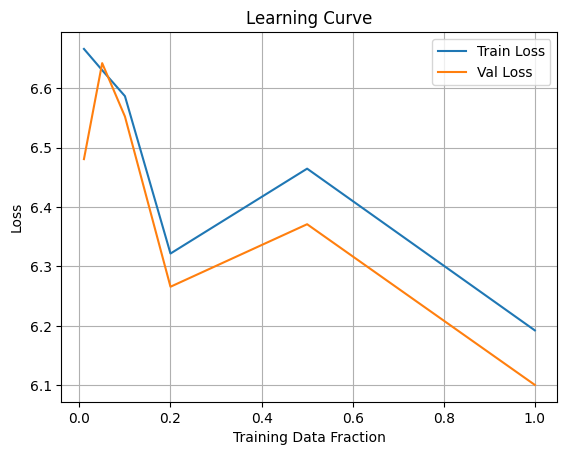

[predict] Loaded 444 rows for prediction


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15703/909478548.py:75: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pred = pd.read_sql(query, conn)
/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15703/909478548.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pred[bool_cols] = df_pred[bool_cols].fillna(False)



--- モデル vs 固定着順 予測精度 ---
1着: モデル=0.550  固定=0.550  (正解数: モデル=244 固定=244)
2着: モデル=0.207  固定=0.225  (正解数: モデル=92 固定=100)
3着: モデル=0.250  固定=0.207  (正解数: モデル=111 固定=92)
4着: モデル=0.196  固定=0.173  (正解数: モデル=87 固定=77)
5着: モデル=0.223  固定=0.212  (正解数: モデル=99 固定=94)
6着: モデル=0.221  固定=0.266  (正解数: モデル=98 固定=118)


In [11]:


# .ipynbを.pyに変換しておく
if __name__ == "__main__":
    import nbformat
    from nbconvert import PythonExporter

    with open("main.ipynb", "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    exporter = PythonExporter()
    source, _ = exporter.from_notebook_node(nb)

    with open("main.py", "w", encoding="utf-8") as f:
        f.write(source)


# ============================================================
# ★ 予測用スクリプト（直近3ヶ月データを使って予測） ★
# ============================================================

def run_experiment(data_frac, df_full, mode="zscore", epochs=5, device="cpu"):
    df_frac = df_full.sample(frac=data_frac, random_state=42)
    df_frac["race_date"] = pd.to_datetime(df_frac["race_date"]).dt.date
    latest_date = df_frac["race_date"].max()
    cutoff = latest_date - dt.timedelta(days=90)  # last 3 months used as validation set
    ds_train = BoatRaceDataset(df_frac[df_frac["race_date"] < cutoff], mode=mode)
    ds_val = BoatRaceDataset(df_frac[df_frac["race_date"] >= cutoff], mode=mode)

    loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=512)

    model = SimpleCPLNet().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        for ctx, boats, lane_ids, ranks in loader_train:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            loss = pl_nll(model(ctx, boats, lane_ids), ranks)
            opt.zero_grad(); loss.backward(); opt.step()

    train_loss = evaluate_model(model, ds_train, device)
    val_loss = evaluate_model(model, ds_val, device)
    return train_loss, val_loss

# 学習曲線の描画
def plot_learning_curve(df, device):
    data_fracs = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
    results = []

    for frac in data_fracs:
        tr_loss, val_loss = run_experiment(frac, df, device=device)
        print(f"Data frac {frac:.2f} → Train: {tr_loss:.4f} / Val: {val_loss:.4f}")
        results.append((frac, tr_loss, val_loss))

    fracs, tr_losses, val_losses = zip(*results)
    plt.plot(fracs, tr_losses, label="Train Loss")
    plt.plot(fracs, val_losses, label="Val Loss")
    plt.xlabel("Training Data Fraction")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def predict_latest_3months():
    import datetime as dt
    today = dt.date.today()
    three_months_ago = today - dt.timedelta(days=90)

    query = f"""
        SELECT * FROM feat.train_features
        WHERE race_date BETWEEN '{three_months_ago}' AND '{today}'
    """
    df_pred = pd.read_sql(query, conn)
    print(f"[predict] Loaded {len(df_pred)} rows for prediction")

    # --- 前処理 ---
    df_pred["wind_dir_rad"] = np.deg2rad(df_pred["wind_dir_deg"])
    df_pred["wind_sin"] = np.sin(df_pred["wind_dir_rad"])
    df_pred["wind_cos"] = np.cos(df_pred["wind_dir_rad"])
    df_pred[NUM_COLS] = scaler.transform(df_pred[NUM_COLS])

    bool_cols = [c for c in df_pred.columns if c.endswith("_fs_flag")]
    df_pred[bool_cols] = df_pred[bool_cols].fillna(False)
    rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
    df_pred[rank_cols] = df_pred[rank_cols].fillna(7).astype("int32")

    pred_ds = BoatRaceDataset(df_pred, mode="zscore")
    pred_loader = DataLoader(pred_ds, batch_size=1)

    model.eval()
    for i, (ctx, boats, lane_ids, _) in enumerate(pred_loader):
        ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
        with torch.no_grad():
            scores = model(ctx, boats, lane_ids)  # (1,6)
            pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1
            # print(f"[{i:03d}] 予測順位:", pred_rank.cpu().numpy())

    # --- 追加: 固定着順との比較評価 ---
    def evaluate_against_fixed_ranks(pred_loader):
        """
        着順 [1,2,3,4,5,6] を常に予測したと仮定した場合と、モデルの予測を比較する
        """
        model_correct = [0] * 6
        fixed_correct = [0] * 6
        total = 0

        model.eval()
        for _, (ctx, boats, lane_ids, true_ranks) in enumerate(pred_loader):
            ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
            true_ranks = true_ranks.to(device)

            with torch.no_grad():
                scores = model(ctx, boats, lane_ids)
                pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1  # (6,)

            total += 1
            for i in range(6):
                # モデルがその艇の着順を当てたか
                if pred_rank[i].item() == true_ranks[0][i].item():
                    model_correct[i] += 1
                # 固定予測 [1,2,3,4,5,6] を使った場合
                if (i + 1) == true_ranks[0][i].item():
                    fixed_correct[i] += 1

        print("\n--- モデル vs 固定着順 予測精度 ---")
        for i in range(6):
            print(f"{i+1}着: モデル={model_correct[i]/total:.3f}  固定={fixed_correct[i]/total:.3f}  (正解数: モデル={model_correct[i]} 固定={fixed_correct[i]})")

    evaluate_against_fixed_ranks(pred_loader)

# 呼び出し例
if __name__ == "__main__":
    plot_learning_curve(processed_df, device)
    predict_latest_3months()